In [11]:
import pandas_profiling
import pandas as pd

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
dados = '/content/drive/MyDrive/Projeto_Cientista_de_Dados/Projeto Cientista de Dados/MinerandoDados_curso/data.csv'

In [14]:
dados_df = pd.read_csv(dados, sep=',', header=0, encoding= 'unicode_escape')

In [15]:
dados_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [16]:
dados_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [17]:
pandas_profiling.ProfileReport(dados_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
profile = pandas_profiling.ProfileReport(dados_df)

In [21]:
# Gerando a página html
profile.to_file("dados.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
import datetime as dt 
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
dados_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [24]:
# A coluna InvoiceDate está como Object, vamos converter a coluna em dados para que seja possível a criação de operações com ela
dados_df["InvoiceDate"] = pd.to_datetime(dados_df["InvoiceDate"])

In [25]:
# Criando a função que iniciou a data, forçando o primeiro dia do mês
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [26]:
# Entrega o primeiro dia do mês da InvoiceDate
dados_df['InvoiceMonth'] = dados_df['InvoiceDate'].apply(get_month)

In [28]:
# Agora agruparemos pelo mês que iniciou
grouping = dados_df.groupby('CustomerID')['InvoiceMonth']

In [29]:
# Entrega a data que ele foi registrado no dataset de entrada do cliente
dados_df['CohortMonth'] = grouping.transform('min')


In [30]:
## Extrair valores inteiros dos dados
# Antes de podermos calcular o deslocamento de tempo, primeiro criaremos uma função auxiliar que extrairá valores inteiros do ano, mês e dia de um objeto datetime().

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [34]:
# Agora, calcularemos os numeros entre os meses e transição da primeira data
# foi passado o "_" underline pois não queremos verificar o dia, apenas o ano e o mês
invoice_year, invoice_month, _ = get_date_int(dados_df, 'InvoiceMonth')    
cohort_year, cohort_month, _ = get_date_int(dados_df, 'CohortMonth')

In [36]:
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
dados_df['CohortIndex'] = year_diff * 12 + month_diff + 1  # multiplicando por 12 meses e adicionando mais um mês

In [37]:
# Agora vamos calcular o número de clientes ativos mensais em cada coorte. Primeiro, vamos criar um objeto groupby com CohortMonth e CohortIndex. Então contaremos um número de clientes em cada grupo aplicando a função pandas nunique(). Em seguida, redefinimos o indice e criamos um pivô de pandas com CohortMonth nas linhas. CohortIndex nas colunas e CustomerID conta como valores. 
grouping = dados_df.groupby(['CohortMonth', 'CohortIndex'])

In [38]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

In [39]:
# analisando quantos clientes estão voltando para comprar na empresa
cohort_data

CohortMonth  CohortIndex
2010-12-01   1.0            948
             2.0            362
             3.0            317
             4.0            367
             5.0            341
                           ... 
2011-10-01   2.0             93
             3.0             46
2011-11-01   1.0            321
             2.0             43
2011-12-01   1.0             41
Name: CustomerID, Length: 91, dtype: int64

In [40]:
# Convertendo a tabela em PIVOT
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')

In [41]:
# Retornará os valores, cada mês são de acessos unicos para checar quantos estão se mantendo
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Calcular a taxa de retenção

 A retenção mede quantos clientes de cada cohort retornaram nos meses subsequentes. A primeira coluna é o número total de clientes no cohort.

 Em seguida, vamos calcular a proporção de quantos desses clientes voltaram nos mesees subsequentesm que e a taxa de retenção. Uma palavra de cautela, você verá que a retenção do primeiro mês - por definição - será de 100% para todas as cohorts. Isso ocorre porque o número de clientes ativos no primeiro mês é, na verdade, o tamanho da coorte.
 Vamos selecionar a primeira coluna da tabela e armazena-la como cohort_sizes. Em seguida, usaremos a função divide() no dataframe cohort_counts e passaremos o cohort_sizes. Definimos o parâmetro axis como zero para garantir que dividimos ao longo de eixo de linha. Por fim, arredondaremos a proporçao para 3 digitos e multiplicaremos por 100 para parecer uma porcentagem. Com esses comandos simples, concluiremos o calculco da metrica de retenção.


In [42]:
# Guarda a primeira coluna como o tamanho dos cohorts
cohort_sizes = cohort_counts.iloc[:,0]

In [43]:
# Divide todos os valores pelo cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis = 0)

In [44]:
# Recria a tabela de retenção
retention.round(3)*100

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Visualizando a análise de cohort

 Heatmap

 Vamos começar a visualizar as taxas de retenção como um mapa de calor. Em seguida, podemos personalizar essa visualização dependendo do formato dos dados. Em seguida, adicionaremos um título a tabela. E então chamamos a função heatmap(). Passamos a tabela de retenção para o parâmetro de dados e garantimos que os números também sejam impressos passando o valor True para o argumento de anotação. Em seguida, defina o formato como porcentagem com um valor decimal. Os parâmetros vmin e vmax são usados para ancorar o mapa de cores e garantir que os valores discrepantes não afetem a visualização. Finalmente, passamos a paleta Green para o mapa de cores. Você pode encontrar várias outras paletas de cores na documentação do Seaborn. Agora podemos executar a função plot show para dar vida ao mapa de calor.


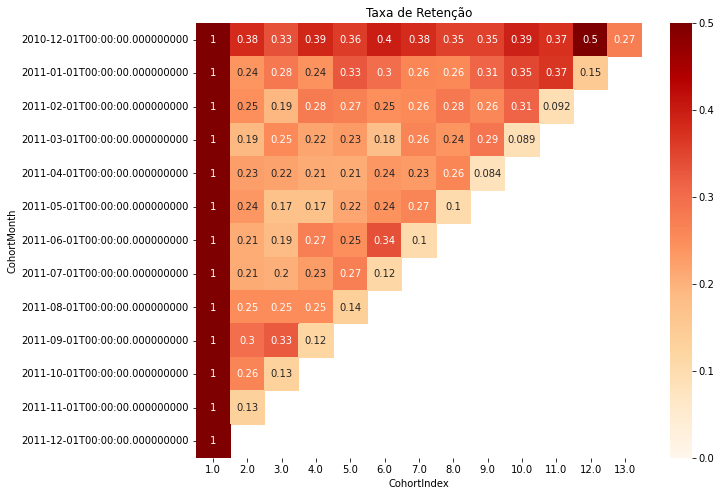

In [49]:
plt.figure(figsize=(10, 8))
plt.title("Taxa de Retenção")

sns.heatmap(
    data = retention,
    annot = True,
    vmin = 0.0,
    vmax = 0.5,
    cmap = 'OrRd' # paleta de cores escolhida
)
plt.show()